Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [2]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [351]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

Text(0.5, 1.0, 'Sigmoid')

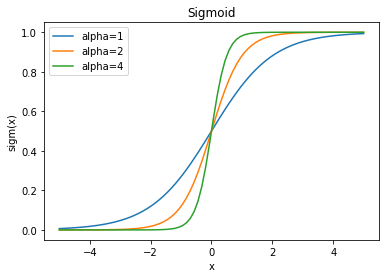

In [449]:
# Vaš kôd ovdje
def sigm(x, alpha=1):
    return 1/(1+np.exp(-alpha*x))

examples = linspace(-5, 5, 80)
plt.plot(examples, sigm(examples, 1), label="alpha=1")
plt.plot(examples, sigm(examples, 2), label="alpha=2")
plt.plot(examples, sigm(examples, 4), label="alpha=4")
plt.xlabel("x")
plt.ylabel("sigm(x)")
plt.legend()
plt.title("Sigmoid")

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [450]:
from numpy import linalg
from sklearn.preprocessing import PolynomialFeatures

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    # Vaš kôd ovdje
    X = PolynomialFeatures(1).fit_transform(X)
    w = [0] * len(X[0])
    w_all_iterations = []
    
    i = 0
    err = epsilon**(-1)
    err_old = 0
    while(i < max_iter) and (abs(err - err_old) >= epsilon):
        delta_w = [0] * len(w)
        
        for j in range(0, len(X)):
            h = lr_h(X[j], w)
            delta_w[0] += (h - y[j])
            delta_w[1:] += (h - y[j])*X[j][1:]
            
        w[0] -= eta*delta_w[0]
        for k in range(1, len(w)): 
            w[k] = (1-eta*alpha)*w[k] - eta*delta_w[k]    
    
        err_old = err
        err = cross_entropy_error(X, y, w) 
        
        if(trace):
            w_all_iterations.append(w.copy())
        i += 1
    
    if trace:
        return(w, w_all_iterations) 
    else:
        return w
        
    
def lr_h(x, w):
    #print(w)
    #print(x)
    return sigm(np.dot(asarray(x).transpose(), w))

def cross_entropy_error(X, y, w):
    predictions = []
    for i in range(len(y)):
        predictions.append(lr_h(X[i], w))
    return sklearn.metrics.log_loss(y, predictions)

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [451]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

Error: 0.13521872720206746


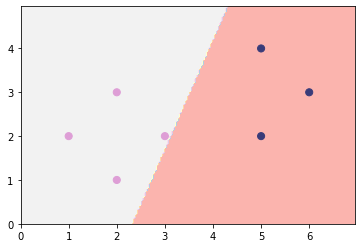

In [453]:
# Vaš kôd ovdje
weights = lr_train(seven_X, seven_y)
trans_seven_X = PolynomialFeatures(degree=1).fit_transform(seven_X)
print("Error: " + str(cross_entropy_error(trans_seven_X, seven_y, weights)))

def plotting(x):
    return PolynomialFeatures(degree=1).fit_transform(x).dot(weights) > 0.5

plot_2d_clf_problem(seven_X, seven_y, plotting)


**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [454]:
from sklearn.metrics import zero_one_loss

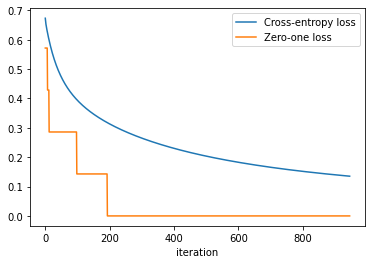

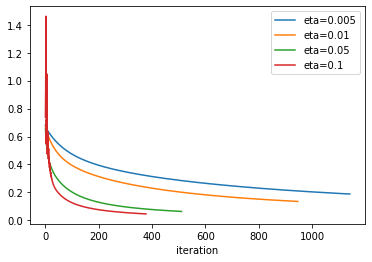

In [455]:
# Vaš kôd ovdje

# first graph

weights_d, trace = lr_train(seven_X, seven_y, trace=True)

def zeroone_y(X, w):
    arr = []
    for i in range(len(X)):
        tmp = lr_h(X[i], w)
        if tmp > 0.5:
            arr.append(1)
        else:
            arr.append(0)
    return arr
    
e_ce = [] # cross entropy error
e_zo = [] # zero-one loss error

for i in range(len(trace)):
    e_ce.append(cross_entropy_error(trans_seven_X, seven_y, trace[i]))
    e_zo.append(zero_one_loss(seven_y, zeroone_y(trans_seven_X, trace[i])))

plt.plot(range(len(trace)), e_ce, label='Cross-entropy loss')
plt.plot(range(len(trace)), e_zo, label='Zero-one loss')
plt.xlabel('iteration')
plt.legend()
plt.show()


# second graph

for eta in [0.005, 0.01, 0.05, 0.1]:
    losses = []
    w, trace_i = lr_train(seven_X, seven_y, eta, trace=True)
    for w_i in trace_i:
        losses.append(cross_entropy_error(trans_seven_X, seven_y, w_i))
    plt.plot(range(len(trace_i)), losses, label="eta=" + str(eta))

plt.xlabel('iteration')
plt.legend()
plt.show()
    


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

My weights: [4.4544945420360165, -1.7108924201238558, 0.6841350736281353]
Their weights: [17.518133479658573, -4.0425675707954065, -0.7188864499516538]


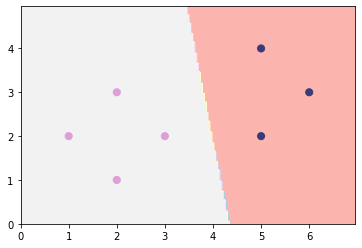

In [456]:
from sklearn.linear_model import LogisticRegression

# Vaš kôd ovdje
logi = LogisticRegression(tol=0.0001, max_iter=2000, C=100)
logi.fit(seven_X, seven_y)
plot_2d_clf_problem(seven_X, seven_y, logi.predict)
print("My weights: " + str(weights))
print("Their weights: [" + str(logi.intercept_[0]) + ", " + str(logi.coef_[0][0]) + ", "+ str(logi.coef_[0][1]) + "]")

### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [457]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

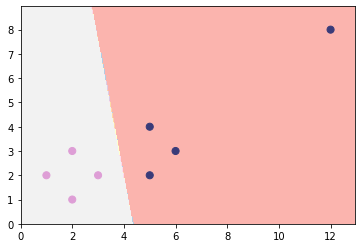

In [458]:
# Vaš kôd ovdje
logi = LogisticRegression(tol=0.0001, max_iter=2000, C=100)
logi.fit(outlier_X, outlier_y)
plot_2d_clf_problem(outlier_X, outlier_y, logi.predict)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

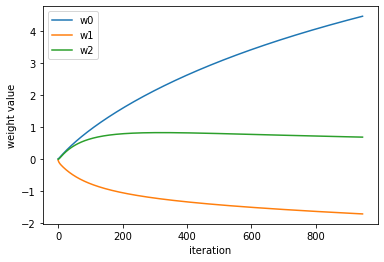

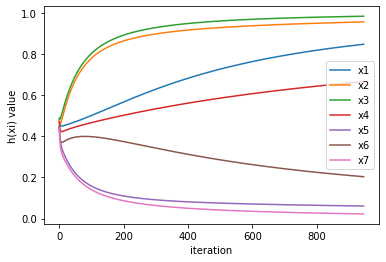

In [459]:
# Vaš kôd ovdje
w, trace = lr_train(seven_X, seven_y, trace=True)

# first graph

w0 = []
w1 = []
w2 = []

for i in range(len(trace)):
    w0.append(trace[i][0])
    w1.append(trace[i][1])
    w2.append(trace[i][2])

plt.plot(w0, label="w0")
plt.plot(w1, label="w1")
plt.plot(w2, label="w2")
plt.xlabel('iteration')
plt.ylabel('weight value')
plt.legend()
plt.show()

# second graph

h = []
for i in range(len(seven_X)):
    h.append([]) 
    
for i in range(len(trace)):
    for j in range(len(seven_X)):
        h[j].append(lr_h(trans_seven_X[j], trace[i]))

for i in range(len(seven_X)):
    plt.plot(h[i], label="x"+str(i+1))

plt.xlabel('iteration')
plt.ylabel('h(xi) value')
plt.legend()
plt.show()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [460]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

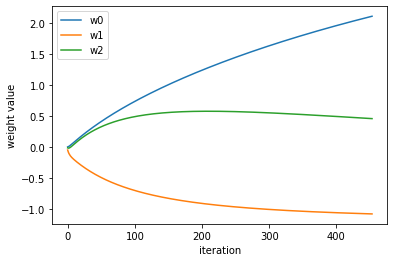

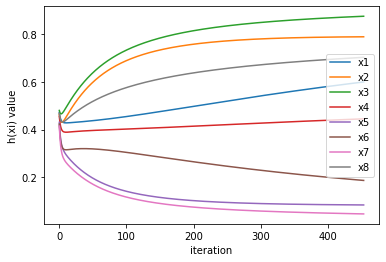

In [462]:
# Vaš kôd ovdje
w, trace = lr_train(unsep_X, unsep_y, trace=True)
trans_unsep_X = PolynomialFeatures(degree=1).fit_transform(unsep_X)

# first graph

w0 = []
w1 = []
w2 = []

for i in range(len(trace)):
    w0.append(trace[i][0])
    w1.append(trace[i][1])
    w2.append(trace[i][2])

plt.plot(w0, label="w0")
plt.plot(w1, label="w1")
plt.plot(w2, label="w2")
plt.xlabel('iteration')
plt.ylabel('weight value')
plt.legend()
plt.show()

# second graph

h = []
for i in range(len(unsep_X)):
    h.append([]) 
    
for i in range(len(trace)):
    for j in range(len(unsep_X)):
        h[j].append(lr_h(trans_unsep_X[j], trace[i]))

for i in range(len(unsep_X)):
    plt.plot(h[i], label="x"+str(i+1))

plt.xlabel('iteration')
plt.ylabel('h(xi) value')
plt.legend()
plt.show()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [463]:
from numpy.linalg import norm

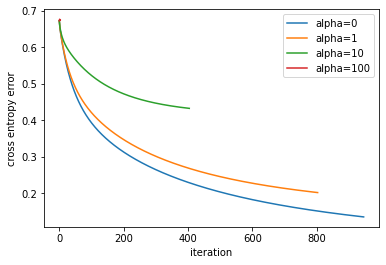

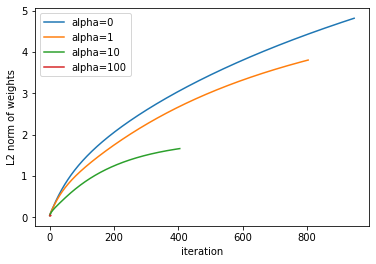

In [464]:
# Vaš kôd ovdje
alphas = [0, 1, 10, 100]

# first graph

for al in alphas:
    w, trace = lr_train(seven_X, seven_y, alpha=al, trace=True)
    err = []
    for i in range(0, len(trace)):
        err.append(cross_entropy_error(trans_seven_X, seven_y, trace[i]))  
    
    plt.plot(err, label="alpha=" + str(al))
    
plt.legend()
plt.xlabel('iteration')
plt.ylabel('cross entropy error')
plt.show()

# second graph

for al in alphas:
    w, trace = lr_train(seven_X, seven_y, alpha=al, trace=True)
    norms = []
    for i in range(0, len(trace)):
        norms.append(norm(trace[i]))  
    
    plt.plot(norms, label="alpha=" + str(al))
    
plt.legend()
plt.xlabel('iteration')
plt.ylabel('L2 norm of weights')
plt.show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [465]:
from sklearn.preprocessing import PolynomialFeatures
#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

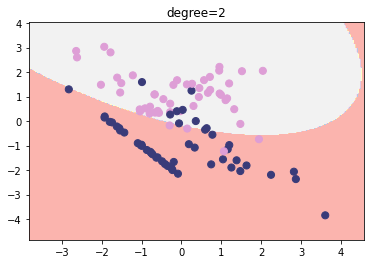

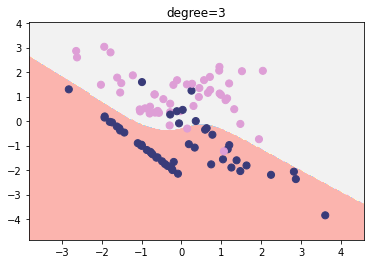

In [466]:
from sklearn.datasets import make_classification

# Vaš kôd ovdje
X, y = make_classification(n_redundant=0, n_classes=2, n_clusters_per_class=2, n_samples=100, n_features=2)
for i in [2,3]:
    pf = PolynomialFeatures(degree=i)
    trans_X = pf.fit_transform(X)

    logreg = LogisticRegression(tol = 0.01, max_iter = 2000).fit(trans_X, y)

    plot_2d_clf_problem(X, y, lambda x : logreg.predict(pf.transform(x)))
    plt.title("degree=" + str(i))
    plt.show()

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?